In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Figure 3.3 --- #

# Cosθ as a function of Enu and Epos and its derivative with respect to Epos 
# Computes cos(theta) for a given antineutrino energy Enu and positron energy Epos, along with the derivative dcosθ/dEpos.
def cost_(Enu,Epos):
    Mn = 939.56542052 # Neutron mass [MeV]
    Mp = 938.27208816 # Proton mass [MeV]
    Me = 0.51099895000 # Electron mass [MeV]
    M = (Mn+Mp)/2
    Delta = Mn - Mp
    y = (Delta**2 - Me**2)/2
    Ee0 = Enu - Delta
    ve0 = np.sqrt(1 - Me**2/Ee0**2)
    
    cost = 1/ve0*(1 - M/Enu*(1-(Epos + y/M)/Ee0))
    dcostdepos = M/(Ee0*Enu*ve0)
    
    return cost, dcostdepos

In [3]:
# Epos as a function of Enu and cosθ and its derivative with respect to cosθ
# Computes the positron energy Epos and the derivative dEpos/dcosθ for given a antineutrino energy Enu and cosθ.
def Ee(Enu, cost):
    Mn = 939.56542052
    Mp = 938.27208816
    Me = 0.51099895000
    M = (Mn+Mp)/2
    Delta = Mn - Mp
    y = (Delta**2 - Me**2)/2
    Ee0 = Enu - Delta
    ve0 = np.sqrt(1 - Me**2/Ee0**2)
    
    Epos = Ee0*(1 - Enu/M*(1 - ve0*cost)) - y/M
    deposdcost = Ee0*Enu*ve0/M
    
    return Epos, deposdcost

In [4]:
# Differential cross-section dσ/dEpos
# Computes the differential IBD cross-section dσ/dEpos [cm^2] for a given antineutrino energy Enu and positron energy Epos.
def cross_IBD(Enu,Epos):
    
    # Physical constants
    Mn = 939.56542052
    Mp = 938.27208816
    Me = 0.51099895000
    M = (Mn+Mp)/2
    Delta = Mn - Mp
    
    # Kinematics
    Ee0 = Enu - Delta
    pe0 = np.sqrt(Ee0**2 - Me**2)
    ve0 = np.sqrt(1 - Me**2/Ee0**2)

    # Couplings and corrections
    f = 1
    f2 = 3.706
    g = 1.26
    G = 1.1663787  # MeV^-2 (factor 1e-11 suppressed)
    Deltainn = 0.024
    ctc = 0.974
    sigma0 = (G**2*ctc**2)/np.pi*(1 + Deltainn) # MeV^-4
    
    # Compute cosθ and its derivative
    cost, dcostdepos = cost_(Enu, Epos)
    
    # Gamma term from paper
    gamma = 2*(f+f2)*g*((2*Ee0 + Delta)*(1 - ve0*cost) - Me**2/Ee0) + \
    (f**2+g**2)*(Delta*(1 + ve0*cost) + Me**2/Ee0) + \
    (f**2+3*g**2)*((Ee0+Delta)*(1-cost/ve0)-Delta) + \
    (f**2-g**2)*((Ee0+Delta)*(1-cost/ve0)-Delta)*ve0*cost

    # If below threshold, σ = 0
    if Epos < Me:
        sigepos=0
    else:
        ve1 = np.sqrt(1 - Me**2/Epos**2)
        pe1 = np.sqrt(Epos**2 - Me**2)
        
        # dσ/dcosθ
        dsigdcost = sigma0/2*((f**2+3*g**2)+(f**2-g**2)*ve1*cost)*Epos*pe1 - \
        sigma0/2*gamma/M*Ee0*pe0
        
        # dσ/dEpos
        sigepos = dsigdcost*dcostdepos

    # Unit conversion MeV^-2 -> cm^2 (plus factor 1e-22 suppressed in paper)
    mevtocm=(1e6*5.068e4)**2.
    sigepos=sigepos/mevtocm*1e-22

    return sigepos

In [5]:
# Total cross-section σ_tot(Enu)
# Computes the total IBD cross-section σ_tot(Enu) [cm^2] by integrating dσ/dEpos over allowed Epos.
def total_cs(Enu):
    
    Me = 0.51099895000 # Electron mass [MeV]
    
    # Allowed Epos range from kinematics
    Eposmin,deposdcost=Ee(Enu,-1)
    Eposmax,deposdcost=Ee(Enu,1)

    if Eposmin < Me: 
        Eposmin = Me
    
    # Integrating
    Eposlist = np.linspace(Eposmin,Eposmax,101)
    sigtot = []
    sigenu=[]
    
    # Evaluating dσ/dEpos at each Epos
    for Epos in Eposlist:
        sigenu.append(cross_IBD(Enu,Epos))
    
    # Integrating over Epos
    sigtot = np.trapz(sigenu,Eposlist)
    
    return sigtot

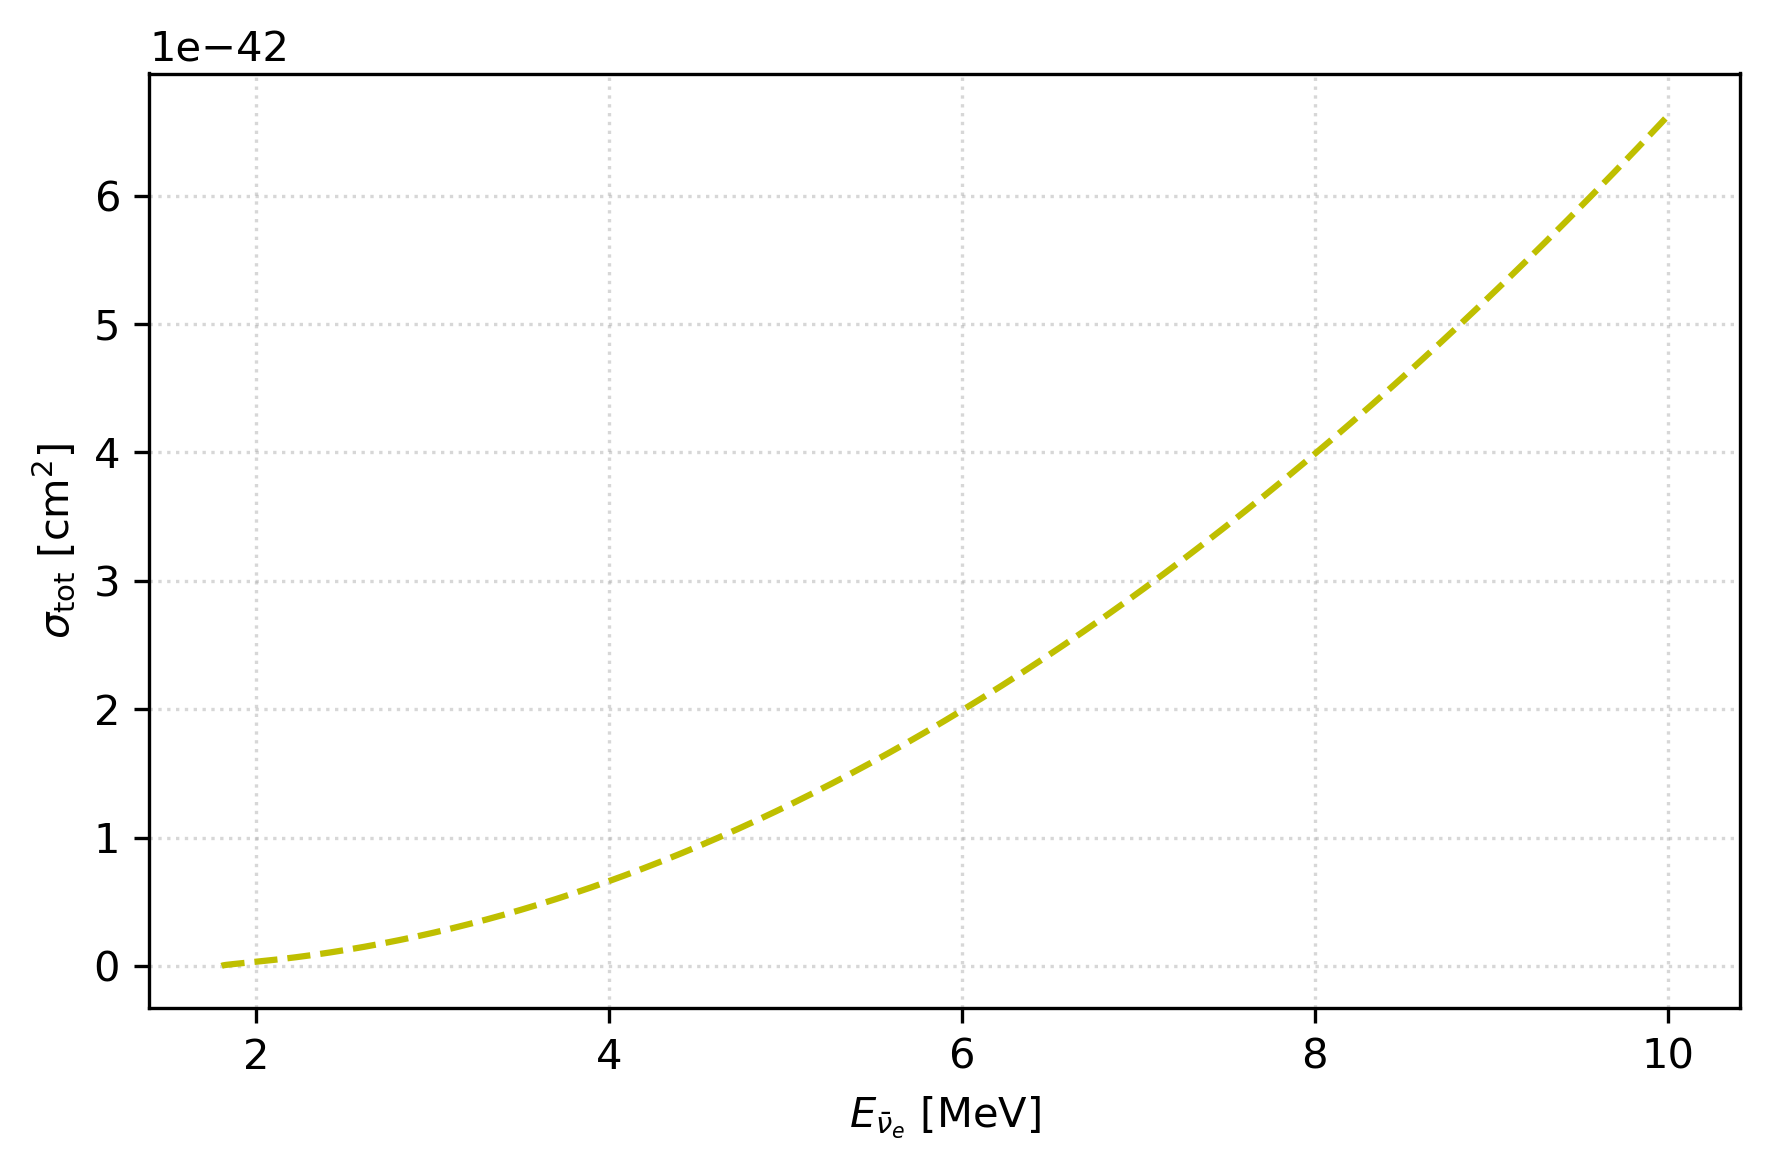

In [6]:
# Defining the antineutrino energy range [MeV]
Enu = np.linspace(1.806,10,1001)

# List to store the total cross-section values and looping over antineutrino energies
sigmas = []
for i in Enu:
    sigmas.append(total_cs(i))

# Plotting
plt.figure(dpi=300)
plt.plot(Enu, sigmas, '--y', label = 'Total cross section')
plt.xlabel(r'$E_{\bar{\nu}_e} \ [\text{MeV}]$')
plt.ylabel(r'$\sigma_\text{tot} \ [\text{cm}^{2}]$')
plt.grid(alpha = 0.5, ls = ':')
plt.tight_layout()
plt.show()